In [ ]:
# Install dependencies
!pip install langchain
!pip install openai
!pip install python-dotenv
!pip install tabulate
!pip install Jinja2
!pip install reportlab

In [ ]:
# Load in OpenAI API Key
import os
from dotenv import load_dotenv

# Load the .env file
load_dotenv()

# Get the OpenAI API key
openai_api_key = os.getenv('OPENAI_API_KEY')

In [154]:
# Clean the dataset
import pandas as pd
import numpy as np

# Read the csv file
df = pd.read_csv('datasets/winequality-red.csv')

# Handle missing values
for col in df.columns:
    if pd.api.types.is_numeric_dtype(df[col]):
        # For numeric columns, fill missing values with the mean
        df[col].fillna(df[col].mean(), inplace=True)
    else:
        # For other types of columns (e.g. dates, custom classes), fill missing values with a new category 'missing'
        df[col].fillna('missing', inplace=True)

# Save the cleaned dataset
df.to_csv('cleaned_dataset.csv', index=False)


In [155]:
# Create our CSV agent
from langchain.agents import create_csv_agent
from langchain.llms import OpenAI
csv_agent = create_csv_agent(
    OpenAI(temperature=0), 
    'cleaned_dataset.csv', 
    verbose=True)

In [156]:
# Identify the dependent varaible
dv_prompt = "Please examine the dataset and suggest a potential dependent variable. Consider factors such as the name of the column, the type of the data, and the distribution of the values. The dependent variable is typically the outcome we are interested in predicting or explaining. If the dataset appears to be from a time-series study, consider the variable that changes over time as the dependent variable. If the dataset seems to be from an experimental study, consider the variable that is expected to have been affected by the treatments or conditions as the dependent variable. If the dataset seems to be observational, consider the variable that seems most likely to be affected by other variables in the dataset as the dependent variable. Output only the name of the column."
dv = csv_agent.run(dv_prompt)

In [157]:
# Generate analyses
import matplotlib.pyplot as plt 
analyses = {}

In [158]:
# First analysis: descriptive statistics
statistics = csv_agent.run("Output the most relevant descriptive statistics for the {dv} and each of the independent variables. Don't reference something shown above; instead, describe it directly.")
analyses['Descriptive Statistics'] = statistics

In [159]:
# Second analysis: correlation
# Only execute if there are less than 10 independent variables
if len(df.columns) < 10:
    correlation = csv_agent.run("Calculate the most relevant correlation coefficients between the {dv} and each of the numerical independent variables. Don't reference something shown above; instead, describe it directly.")
    analyses['Correlation'] = correlation

<string>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


InvalidRequestError: This model's maximum context length is 4097 tokens, however you requested 8375 tokens (8119 in your prompt; 256 for the completion). Please reduce your prompt; or completion length.

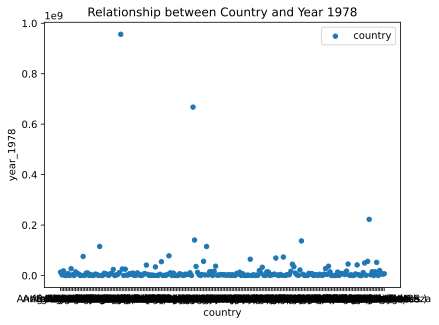

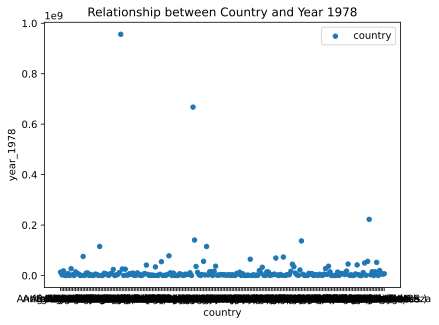

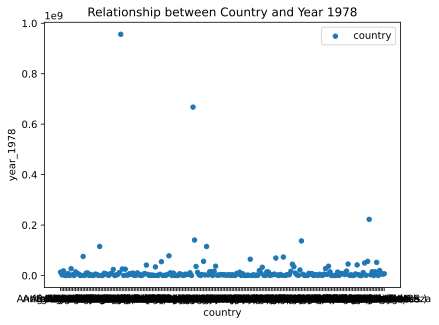

In [160]:
# Third analysis: scatterplot
# Generate the chart itself
scatterplot_code = csv_agent.run("Create the most relevant scatterplot showing the relationship between the {dv} and one of the numerical independent variables. Output the code needed to create the scatterplot, including labels for axes and a title, but don't include imports. Use the format: df.plot.scatter(x='fixed acidity', y='quality', title='Relationship between Fixed Acidity and Quality', label='fixed acidity')")
code = """
plot = """ + scatterplot_code + """
fig = plot.get_figure()
fig.savefig('charts/scatterplot.png')
"""
exec(code)

# Generate the description of the trend in the chart
scatterplot = csv_agent.run("Describe the relationship seen in " + scatterplot_code)
analyses['Scatterplot'] = scatterplot

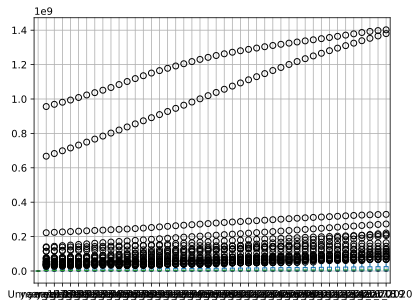

In [161]:
# Fourth analysis: outliers
outliers = csv_agent.run("Identify and list outliers when considering the relationship between the {dv} and each of the independent variables. Don't reference something shown above; instead, describe it directly.")
analyses['Outliers'] = outliers

<string>:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
<string>:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
<string>:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.


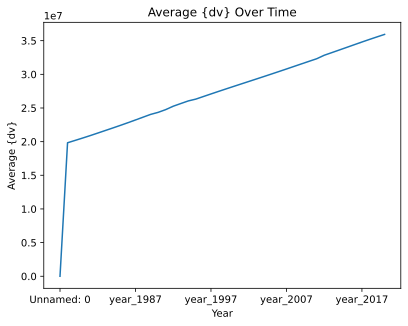

In [162]:
# Fifth analysis: time series
# Generate the chart itself
time_series_code = csv_agent.run("If this dataset is not time-series data, ONLY output \"Irrelevant!\". Otherwise, for time-series data, create a line plot of the average {dv} over time. Output the code needed to create the time series plot, including labels for axes and a title.")

if time_series_code == "Irrelevant!":
    time_series = "Irrelevant!"
else:
    code = """
plot = """ + time_series_code + """
fig = plot.get_figure()
fig.savefig('charts/time_series.png')
"""
    exec(code)

    # Generate the description of the trend in the chart
    time_series = csv_agent.run("Describe the trend seen in " + time_series_code)
analyses['Time Series'] = time_series


In [163]:
# Sixth analysis: PCA
pca = csv_agent.run("Perform a principle component analysis (PCA) with the {dv} and all independent numerical variables, and return the explained variance ratio of the first two principal components")
analyses['PCA'] = pca

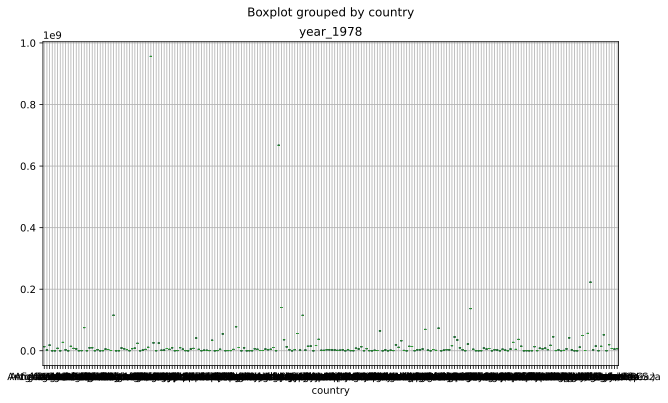

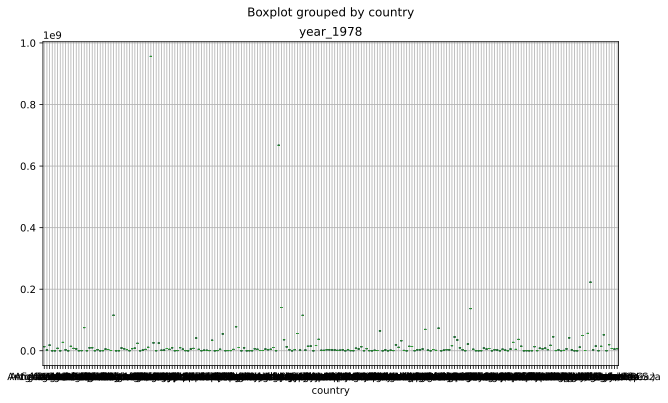

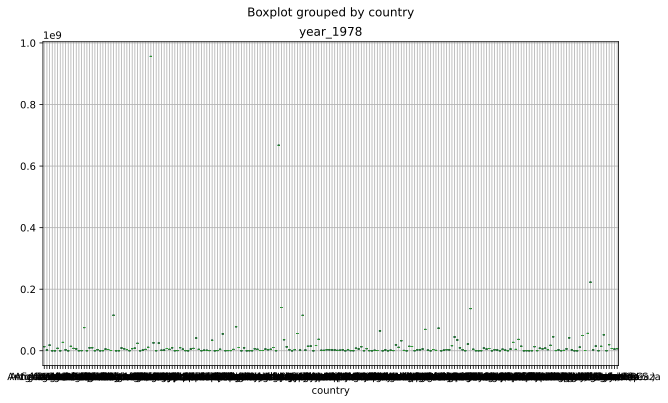

In [164]:
# Seventh analysis: Box plot
# Generate the chart itself
box_plot_code = csv_agent.run("Create the most relevant box plot of the {dv} for one of the categorical independent variables. Output the code needed to create the box plot, including labels for axes, but don't include imports. Don't include too many values on the axes. Use the format: df.boxplot(column='alcohol', by='quality', figsize=(10,6))")
code = """
plot = """ + box_plot_code + """
fig = plot.get_figure()
fig.savefig('charts/boxplot.png')
"""
exec(code)

# Generate the description of the trend in the chart
box_plot = csv_agent.run("Describe the relationship seen in " + box_plot_code)
analyses['Box Plot'] = box_plot

In [165]:
# Currently not working
"""
# Eighth analysis: Histogram
# Generate the chart itself
histogram_code = csv_agent.run("Create a histogram for {dv}. Output the code needed to create the histogram, including labels for axes and a title, but don't include imports.")
"""

#code = """
#plot = """ + histogram_code + """
#fig = plot.get_figure()
#fig.savefig('charts/histogram.png')
#"""

"""
exec(code)

# Generate the description of the trend in the chart
histogram = csv_agent.run("Describe the relationship seen in " + histogram_code)
analyses['Histogram'] = histogram
"""

'\nexec(code)\n\n# Generate the description of the trend in the chart\nhistogram = csv_agent.run("Describe the relationship seen in " + histogram_code)\nanalyses[\'Histogram\'] = histogram\n'

In [166]:
# print all data analyses
from tabulate import tabulate
print(tabulate(analyses.items(), headers=['Analysis', 'Description']))

In [167]:
# Create our writer agent
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain

# 0 temp for consistent decision making
llm = OpenAI(temperature=0)

# Ask our llm to pick the four most relevant analyses
focus_prompt = PromptTemplate(
    input_variables=['analyses', 'dv'],
    template="Given the nature of the identified dependent variable, {dv}, and the insights provided by the following analyses, please select the four most relevant ones to be included in our final report. Output only the titles of each chosen analyses. \n Analyses: {analyses}",
)

# Generate the output
chain = LLMChain(llm=llm, prompt=focus_prompt)
chosen = chain.run(analyses=analyses, dv=dv)

In [168]:
print(chosen)

In [169]:
# Create our new list of analyses based off the chosen ones
chosen_analyses = chosen.split('\n')

# Filter out any empty strings
chosen_analyses = [title for title in chosen_analyses if title]

# Create the new dictionary
selected_analyses = {title: analyses[title] for title in chosen_analyses if title in analyses}

print(selected_analyses)


In [170]:
# Increased temp for more creative writing
llmc = OpenAI(temperature=0.5)

# Generate the report research question, title, abstract, and conclusion
research_question_prompt = PromptTemplate(
    input_variables=['selected_analyses', 'dv'],
    template="Given the nature of the identified dependent variable, {dv}, and the insights provided by the following analyses, please write a research question that these analyses could answer. \n Analyses: {selected_analyses}",
)

# Generate the output
chain = LLMChain(llm=llmc, prompt=research_question_prompt)
research_question = chain.run(selected_analyses=selected_analyses, dv=dv)

print(research_question)

In [171]:
# Generate the title for this report
title_prompt = PromptTemplate(
    input_variables=['research_question'],
    template="Given the research question, \"{research_question}\", please write a title for this report.",
)

# Generate the output
chain = LLMChain(llm=llmc, prompt=title_prompt)
title = chain.run(research_question=research_question)

print(title)

In [172]:
# Generate the abstract for this report
abstract_prompt = PromptTemplate(
    input_variables=['research_question', 'title', 'selected_analyses'],
    template="Given the research question, \"{research_question}\", and the title, \"{title}\", please write an abstract for this report that describes the data and expands upon the potential real-world implications of it. \n Analyses: {selected_analyses}",
)

# Generate the output
chain = LLMChain(llm=llmc, prompt=abstract_prompt)
abstract = chain.run(research_question=research_question, title=title, selected_analyses=selected_analyses)

print(abstract)

In [173]:
# Generate the introduction for this report that expands upon the abstract without repeating the data analyses
introduction_prompt = PromptTemplate(
    input_variables=['research_question', 'title', 'abstract'],
    template="Given the research question, \"{research_question}\", and the title, \"{title}\", please write an introduction for this report that expands upon the abstract without repeating the data analyses. Don't include a header, just output the text. \n Abstract: {abstract}",
)

# Generate the output
chain = LLMChain(llm=llmc, prompt=introduction_prompt)
introduction = chain.run(research_question=research_question, title=title, abstract=abstract)

print(introduction)

In [174]:
# Generate the conclusion for this report based off the research question, title, selected analyses, and introduction
conclusion_prompt = PromptTemplate(
    input_variables=['research_question', 'title', 'selected_analyses', 'introduction'],
    template="Given the research question, \"{research_question}\", and the title, \"{title}\", please write a conclusion for this report that summarizes the findings of the analyses and the implications of the results. \n Analyses: {selected_analyses} \n Introduction: {introduction} \n Use the format: Conclusion: ",
)

# Generate the output
chain = LLMChain(llm=llmc, prompt=conclusion_prompt)
conclusion = chain.run(research_question=research_question, title=title, selected_analyses=selected_analyses, introduction=introduction)

print(conclusion)

In [175]:
# For each analysis, generate 2-3 paragraphs of text that describe the analysis and its implications in relation to the research question
analysis_prompt = PromptTemplate(
    input_variables=['analysis', 'research_question'],
    template="Given the research question, \"{research_question}\", please write one long paragraph discussing the analysis process, key findings, their relevance to the research question, and potential implications. Don't include subheaders. \n Analysis: {analysis}",
)

# Generate the output
chain = LLMChain(llm=llm, prompt=analysis_prompt)
analysis_descriptions = {}
for analysis in selected_analyses:
    analysis_description = chain.run(analysis=analysis, research_question=research_question)
    analysis_descriptions[analysis] = analysis_description

print(analysis_descriptions)

In [176]:
from reportlab.lib.pagesizes import letter, inch
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image, PageBreak
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib import colors

def footer_canvas(c):
    """
    Add the Page number to the canvas
    """
    c.saveState()
    pageNum = c.getPageNumber()
    c.drawString(letter[0] - inch, 0.75 * inch, f"Page {pageNum}")
    c.restoreState()

# Create a PDF document
doc = SimpleDocTemplate("report.pdf", pagesize=letter, onPage=footer_canvas)

# Set up styles
styles = getSampleStyleSheet()

title_style = ParagraphStyle(
    'Title',
    parent=styles['Heading1'],
    fontName='Helvetica-Bold',
    fontSize=24,
    textColor=colors.HexColor(0x005B96),
    spaceAfter=12,
)

header_style = ParagraphStyle(
    'Header',
    parent=styles['Heading2'],
    fontName='Helvetica-Bold',
    fontSize=20,
    textColor=colors.HexColor(0x6495ED),
    spaceAfter=12,
)

subheader_style = ParagraphStyle(
    'Subheader',
    parent=styles['Heading3'],
    fontName='Helvetica-Bold',
    fontSize=16,
    textColor=colors.HexColor(0xA2D5F2),
    spaceAfter=12,
)

paragraph_style = ParagraphStyle(
    'BodyText',
    parent=styles['BodyText'],
    fontName='Helvetica',
    fontSize=12,
    textColor=colors.black,
    leading=14,
    spaceAfter=12,
)


In [177]:
# Function to remove headers from analyses

import re

def split_and_remove(s):
    # regex pattern to find characters between ":" and the last "." that occurs before each ":"
    pattern = r'\.[^\.]*?:'

    # split the string using regex
    split_strings = re.split(pattern, s)

    # remove empty strings
    split_strings = list(filter(None, split_strings))

    return split_strings


In [178]:
# Add elements (text and images) to the PDF
elements = []

# Add a title
elements.append(Paragraph(title, title_style))
elements.append(Spacer(1, 12))

# Add a the abstract header and text
subtitle = "Abstract"
elements.append(Paragraph(subtitle, header_style))

elements.append(Paragraph(abstract, paragraph_style))
elements.append(Spacer(1, 12))

# Add the introduction header and text
subtitle = "Introduction"
elements.append(Paragraph(subtitle, header_style))

elements.append(Paragraph(introduction, paragraph_style))
elements.append(Spacer(1, 12))

# Add the analyses header and text
subtitle = "Analyses"
elements.append(Paragraph(subtitle, header_style))

for analysis, description in selected_analyses.items():
    # Add title
    elements.append(Paragraph(analysis, subheader_style))

    # Split description into sections
    sections = split_and_remove(analysis_descriptions[analysis])

    for i, content in enumerate(sections):
        # For the first section, add analysis title
        if i == 0:
            content = analysis + content
            # Check if the title is one of the specified figures
            if analysis == "Scatterplot":
                elements.append(Image("charts/scatterplot.png", width=5*inch, height=3*inch))
            elif analysis == "Box Plot":
                elements.append(Image("charts/boxplot.png", width=5*inch, height=3*inch))
            elif analysis == "Histogram":
                elements.append(Image("charts/histogram.png", width=5*inch, height=3*inch))
            elif analysis == "Time Series":
                elements.append(Image("charts/time_series.png", width=5*inch, height=3*inch))

        # Add text to the document
        elements.append(Paragraph(content, paragraph_style))

    elements.append(Spacer(1, 12))



# Add the conclusion header and text
subtitle = "Conclusion"
elements.append(Paragraph(subtitle, header_style))

# Remove "Conclusion: " prefix if it exists
conclusion = conclusion.replace("Conclusion:", "", 1)

elements.append(Paragraph(conclusion, paragraph_style))
elements.append(Spacer(1, 12))

# Page break (optional)
elements.append(PageBreak())

# Build the PDF document with the elements
doc.build(elements)
